In [2]:
%load_ext autoreload 
%autoreload 2
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import *
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm
# market_data = pd.read_parquet('data/US/test_mkt_data.pq')
# GICS = pd.read_parquet('data/US/GICS.pq')
# P = pd.read_parquet('data/US/test_adv_table.pq')
# market_data.dropna().sample(5)
# market_features = pd.read_parquet('data/US/market_features.pq')
# R = market_features['daily_returns'].unstack()
# del market_data

In [3]:
market_features = pd.read_parquet('data/US/market_features_pca.pq')

In [4]:
market_features

,,close,srs,daily_returns,mom_1m,mom_2m,mom_4m,mom_6m,mom_8m,mom_12m,mom_16m,mom_18m,mom_24m,mom_30m,mom_36m,mom_42m
Date,Ticker,,,,,,,,,,,,,,,
2003-07-11,A,21.7000,21.7000,0.030389,3.123747,3.478528,3.930097,0.380940,1.383621,-0.137473,-0.521574,-0.374778,-0.284774,-0.429354,-0.403144,-0.336842
2003-07-14,A,22.1501,22.1501,0.020742,3.689602,3.821185,3.674569,0.395746,1.513364,-0.126092,-0.497930,-0.351985,-0.232170,-0.433819,-0.396412,-0.322444
2003-07-15,A,22.2300,22.2300,0.003607,3.673890,3.828641,3.466019,0.465596,1.684730,-0.099491,-0.494304,-0.331129,-0.224672,-0.417394,-0.391223,-0.314750
2003-07-16,A,21.9399,21.9399,-0.013050,2.946876,3.286293,2.942352,0.356838,1.548381,-0.101446,-0.540693,-0.325231,-0.196646,-0.411588,-0.396497,-0.331232
2003-07-17,A,21.1000,21.1000,-0.038282,2.030146,2.919140,2.234747,0.411547,1.508396,-0.124780,-0.565232,-0.358238,-0.187895,-0.421321,-0.400479,-0.346963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,ZTS,197.0400,197.0400,-0.000862,1.089686,0.110934,0.939923,0.298414,0.462203,0.284336,0.444276,0.248676,0.031944,-0.031971,0.137203,0.122088
2024-02-27,ZTS,199.0000,199.0000,0.009947,0.820175,0.187980,1.133271,0.309758,0.435731,0.343729,0.436094,0.260909,0.055851,-0.020455,0.146521,0.134728
2024-02-28,ZTS,199.9400,199.9400,0.004724,0.782216,0.162113,1.390634,0.242593,0.478740,0.364552,0.410555,0.242524,0.041195,-0.015374,0.162012,0.130407


In [293]:
intraday_data = pd.read_parquet('data/US/test_intraday_data_1h.pq')

In [295]:

close_intraday = intraday_data['close'].unstack().dropna(axis=0,how='all')
close_intraday.index = pd.to_datetime(close_intraday.index)
ret_intraday = np.log(1+ close_intraday.pct_change()).clip(-1,1)
# ret_intraday = ret_intraday.sub(ret_intraday.mean(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_2716\3700967350.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_intraday = np.log(1+ close_intraday.pct_change()).clip(-1,1)


In [296]:
ret_square = ret_intraday **2
RV = ret_square.resample('D').sum().reindex_like(P)
RV_plus = ret_square[ret_intraday>0].resample('D').sum().reindex_like(P)
RV_minus = ret_square[ret_intraday<0].resample('D').sum().reindex_like(P)
SJ = RV_plus - RV_minus
RSJ = SJ / RV
RSJ = RSJ.dropna(axis=0,how='all')
RSJ.resample('5D',closed = 'right').sum().shift()

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABK,ABMD,ABT,...,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-12,-0.571592,0.086577,-0.904033,0.705873,0.804361,0.968430,-0.565475,0.0,0.881895,0.049637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-17,0.696489,0.881583,-0.301728,-0.118463,-2.014548,-1.280373,1.715403,0.0,1.272839,-0.364097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-22,0.473979,1.722790,1.212992,-0.421391,-0.854583,-0.429387,0.454300,0.0,-1.211768,0.509604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-27,-0.268565,-0.765607,-2.653353,0.123050,0.404208,-1.458035,0.434934,0.0,1.796687,-0.790815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-09,-0.128059,-0.746718,0.280933,-1.234200,1.142660,1.879857,0.000000,0.0,0.000000,-1.548951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-14,-0.294491,0.786879,0.125045,0.539202,-1.680127,0.003304,0.000000,0.0,0.000000,0.814187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-19,0.347313,0.608501,0.040315,0.508981,-0.900874,1.169827,0.000000,0.0,0.000000,0.956232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\marti\AppData\Local\Temp\ipykernel_2716\2654408522.py:4: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe                   -0.7
Daily Turnover (%)        3.9
biais (bp)               -1.2
Sharpe since 2022        -1.1
biais  since 2022 (bp)   -1.6
dtype: float64

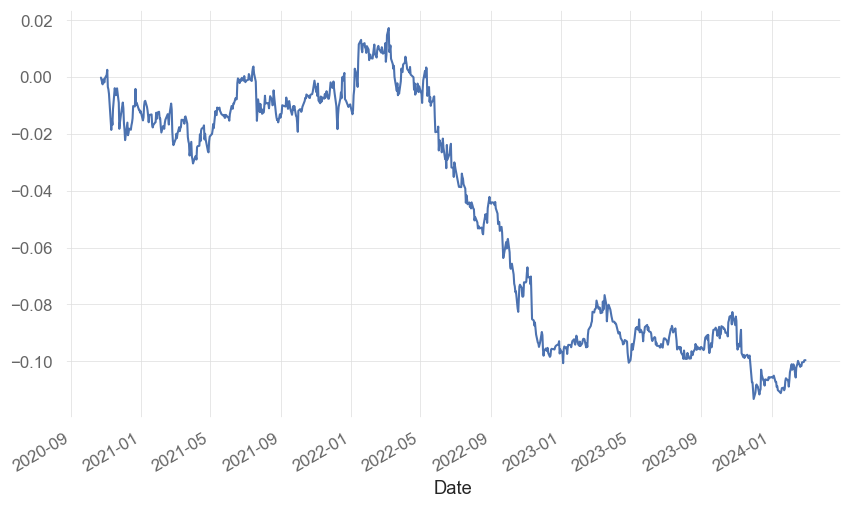

In [297]:
signal = RSJ.resample('5D').sum().shift()
signal = signal.reindex_like(P)[P].ffill()[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal.sub(signal.mean(1),0)
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)
PNL = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

In [ ]:
cube_square = ret_intraday **3
RSK =  cube_square.resample('D').sum()
RSK =  RSK / (RV **(3/2))
RSK.stack().describe

In [ ]:
signal = RSK.rolling(5).sum()
signal = signal.reindex_like(P)[P].ffill()[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal.sub(signal.mean(1),0)
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)
PNL = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

In [ ]:
four_square = ret_intraday **4
RKT =  four_square.resample('D').sum()
n = four_square.resample('D').count()
RKT =  n * RKT / (RV **(2))
RKT.stack().describe()

In [ ]:
RSK= RSK.reindex_like(RSJ)
RKT= RKT.reindex_like(RSJ)
residuals = pd.DataFrame(index=RSK.index, columns=RSK.columns)
a = RSJ.copy()
b = RSK.copy()
c = RKT.copy()
# Iterate through each ticker column
for date in a.index:
    X = b.loc[date].fillna(0).values
    Y = a.loc[date].fillna(0).values
    reshaped_array = X.reshape(-1, 1)
    # Create a column of ones with shape (60, 1)
    ones_column = c.loc[date].fillna(0).values.reshape(-1, 1)
    # Concatenate the original array and the column of ones to get a (60, 2) array
    X = np.hstack((reshaped_array, ones_column))
    beta = np.linalg.inv((X.T @ X)) @ X.T @ Y
    Y_pred = X @ beta
    residuals_day = Y - Y_pred
    
    # Store the residuals
    residuals.loc[date] = residuals_day
    
residuals.stack()

In [ ]:
signal = RKT
signal = signal.reindex_like(P)[P].ffill()[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal.sub(signal.mean(1),0)
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)
PNL = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

In [ ]:
import os 
import datetime
import requests
import calendar 
ticker ="AAP"
exchange = "US"
interval = "1h"
period_days = 10
to_utc = datetime.datetime.now()

url = "https://eodhistoricaldata.com/api/intraday/{}.{}".format(ticker, exchange)
params = {
    "api_token": os.getenv('EOD_KEY'), 
    "interval": interval,
    "fmt": "json"
}
resp = requests.get(url, params=params)
df = pd.DataFrame(resp.json()).reset_index(drop=True).set_index("datetime")
df.index = pd.to_datetime(df.index)
df

In [ ]:
df.resample('D').count()